In [66]:
import numpy as np
import matplotlib.pyplot as plt

import scipy
import scipy.sparse.linalg

from time import time

import pandas as pd

# install this with "pip install datafold"
import datafold.pcfold as pfold

from large_eigensystems import *
from test_efficiency import *

import tensorflow_federated as tff

from sklearn.neighbors import KNeighborsClassifier

import warnings
from scipy.sparse import SparseEfficiencyWarning
warnings.simplefilter('ignore',SparseEfficiencyWarning)

In [3]:
# parameters
kernel_evecs = 150
cknn_k_neighbor = 25
evec_tol = 1e-4
kernel_tol = 1e-11

In [6]:
# data
cifar_train, cifar_test = tff.simulation.datasets.cifar100.load_data(
    cache_dir=None
)

10000
5000


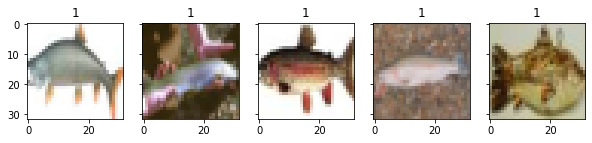

In [70]:
fig,ax = plt.subplots(1,5,figsize=(10,4),sharex=True,sharey=True)

k=0
data_images_train = []
labels_train = []
data_images_test = []
labels_test = []
n_pts_train = 10000
n_pts_test = 5000

for _id in cifar_train.client_ids:
    data = cifar_train.create_tf_dataset_for_client(_id) 
    for element in data:
        if k<ax.shape[0]:
            ax[k].imshow(element["image"])
            ax[k].set_title(str(element["coarse_label"].numpy()))
        k+=1
        data_images_train.append(element["image"].numpy().flatten())
        labels_train.append(element["coarse_label"].numpy())
        if k >= n_pts_train:
            break
    if k >= n_pts_train:
        break
print(len(data_images_train))

data_images_train = np.row_stack(data_images_train)
labels_train = np.row_stack(labels_train)

k=0
for _id in cifar_test.client_ids:
    data = cifar_test.create_tf_dataset_for_client(_id) 
    for element in data:
        if k<ax.shape[0]:
            ax[k].imshow(element["image"])
            ax[k].set_title(str(element["coarse_label"].numpy()))
        k+=1
        data_images_test.append(element["image"].numpy().flatten())
        labels_test.append(element["coarse_label"].numpy())
        if k >= n_pts_test:
            break
    if k >= n_pts_test:
        break
print(len(data_images_test))


data_images_test = np.row_stack(data_images_test)
labels_test = np.row_stack(labels_test)

In [71]:
_te = TestEfficiency(_, _, verbose=True,
                     n_kernel_evecs=kernel_evecs, n_common_evecs=10, 
                     kernel_tol=kernel_tol, evec_tol=evec_tol, cknn_k_neighbor=cknn_k_neighbor,
                     compute_sparse=True, kernel_type="cknn")

In [ ]:

data_images_train_test = np.row_stack([data_images_train, data_images_test])
labels_train_test = np.concatenate([labels_train[:,0], -1+0*data_images_test[:,0]])

kernels = []
print(data_images_train_test.shape)
print(labels_train_test.shape)

for label_ in np.unique(labels_train_test):
    data_current = data_images_train_test[labels_train_test==label_,:]
    # print(data_current.shape)
    
    print("kernel at", data_current.shape[0],"...")
    _k = _te.kernelmatrix(data_current)
    kernels.append(_k)

(15000, 3072)
(15000,)
kernel at 5000 ...


In [ ]:
eigenvectors_ = []

for k in range(len(kernels)):
    print("computing eigenvectors at k=",k)
    Aevals,Aevecs = scipy.sparse.linalg.eigsh(kernels[k], k=_te.n_kernel_evecs, tol=_te.evec_tol, which="LM")
    eigenvectors_.append(Aevecs)
    

In [ ]:
Cevecs_sparse,Cevals_sparse,_ = scipy.sparse.linalg.svds(np.row_stack(eigenvectors_), k=_te.n_common_evecs, which='LM', tol=_te.evec_tol)
Cevals,Cevecs = CommonEigensystemMatrix._sort_eigensystem(_, Cevals_sparse, Cevecs_sparse)

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=15)
neigh.fit(Cevecs[0:n_pts_train,:10], labels_train[:,0]);
score = neigh.score(Cevecs[n_pts_train:,:10], labels_test[:,0])

In [85]:
Cevecs.shape

(10000, 10)